# **Editing graph state**

**Review**

We discussed motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

Goals
Now, let's show how to directly edit the graph state and insert human feedback.

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file with UTF-8 encoding
load_dotenv(encoding='utf-8')

# Get the API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# **Editing state**

Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also opportunities to modify the graph state.

Let's set up our agent with a breakpoint before the assistant node.

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

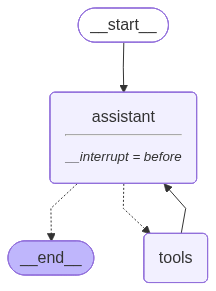

In [5]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run!

We can see the graph is interrupted before the chat model responds.

In [6]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [7]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e69206e9-73b3-48cb-8667-d5a8df6392cc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d9551-6b1b-6038-8000-964f9c666ac3'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-12-15T01:26:32.467666+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0d9551-6b16-621c-bfff-4f4adfa1d349'}}, tasks=(PregelTask(id='0257ffd7-bd08-b5c5-9d5d-4282d1ab6856', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, we can directly apply a state update.

Remember, updates to the messages key will use the add_messages reducer:

If we want to over-write the existing message, we can supply the message id.
If we simply want to append to our list of messages, then we can pass a message without an id specified, as shown below.

In [8]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d9551-6b71-6d76-8001-6ffafad86ad8'}}

Let's have a look.

We called update_state with a new message.

The add_messages reducer appends it to our state key, messages.

In [9]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing None and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes.

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QCrGbaYGELBWleYHZXHqNgqr)
 Call ID: call_QCrGbaYGELBWleYHZXHqNgqr
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


Now, we're back at the assistant, which has our breakpoint.

We can again pass None to proceed.

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


# **Awaiting user input**

So, it's clear that we can edit our agent state after a breakpoint.

Now, what if we want to allow for human feedback to perform this state update?

We'll add a node that serves as a placeholder for human feedback within our agent.

This human_feedback node allow the user to add feedback directly to state.

We specify the breakpoint using interrupt_before our human_feedback node.

We set up a checkpointer to save the state of the graph up until this node.

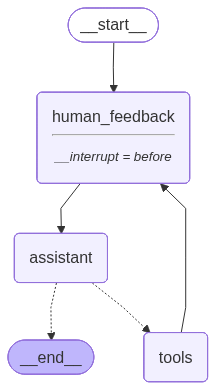

In [14]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))